In [2]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import sympy as sym
plt.style.use('presentation')
%matplotlib notebook

def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item   
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)

In [16]:
psi_ds,psi_qs,psi_dr,psi_qr = sym.symbols('psi_ds,psi_qs,psi_dr,psi_qr')  
i_ds,i_qs,i_dr,i_qr = sym.symbols('i_ds,i_qs,i_dr,i_qr')  
di_ds,di_qs,di_dr,di_qr = sym.symbols('di_ds,di_qs,di_dr,di_qr')  
L_s,L_r,L_m = sym.symbols('L_s,L_r,L_m')  
R_s,R_r = sym.symbols('R_s,R_r') 
omega_s,omega_r,sigma = sym.symbols('omega_s,omega_r,sigma') 
v_ds,v_qs,v_dr,v_qr = sym.symbols('v_ds,v_qs,v_dr,v_qr')  

dpsi_ds = (L_s+L_m)*di_ds + L_m*di_dr  
dpsi_qs = (L_s+L_m)*di_qs + L_m*di_qr  
dpsi_dr = (L_r+L_m)*di_dr + L_m*di_ds  
dpsi_qr = (L_r+L_m)*di_qr + L_m*di_qs  

eq_ds = - dpsi_ds + v_ds + R_s*i_ds + omega_s*psi_qs
eq_qs = - dpsi_qs + v_qs + R_s*i_qs - omega_s*psi_ds
eq_dr = - dpsi_dr + v_dr + R_r*i_dr + sigma*omega_s*psi_qr
eq_qr = - dpsi_qr + v_qr + R_r*i_qr - sigma*omega_s*psi_dr
    
s=sym.solve([eq_ds,eq_qs,eq_dr,eq_qr],[di_ds,di_qs,di_dr,di_qr])

for item in s:
    print(item, '=', s[item])

di_qs = (-L_m*R_r*i_qr + L_m*R_s*i_qs + L_m*omega_s*psi_dr*sigma - L_m*omega_s*psi_ds - L_m*v_qr + L_m*v_qs + L_r*R_s*i_qs - L_r*omega_s*psi_ds + L_r*v_qs)/(L_m*L_r + L_m*L_s + L_r*L_s)
di_dr = (L_m*R_r*i_dr - L_m*R_s*i_ds + L_m*omega_s*psi_qr*sigma - L_m*omega_s*psi_qs + L_m*v_dr - L_m*v_ds + L_s*R_r*i_dr + L_s*omega_s*psi_qr*sigma + L_s*v_dr)/(L_m*L_r + L_m*L_s + L_r*L_s)
di_ds = (-L_m*R_r*i_dr + L_m*R_s*i_ds - L_m*omega_s*psi_qr*sigma + L_m*omega_s*psi_qs - L_m*v_dr + L_m*v_ds + L_r*R_s*i_ds + L_r*omega_s*psi_qs + L_r*v_ds)/(L_m*L_r + L_m*L_s + L_r*L_s)
di_qr = (L_m*R_r*i_qr - L_m*R_s*i_qs - L_m*omega_s*psi_dr*sigma + L_m*omega_s*psi_ds + L_m*v_qr - L_m*v_qs + L_s*R_r*i_qr - L_s*omega_s*psi_dr*sigma + L_s*v_qr)/(L_m*L_r + L_m*L_s + L_r*L_s)


In [10]:
10*3*7/10/10


2.1

In [21]:
# [1] T. Demiray, F. Milano, and G. Andersson, 
# “Dynamic phasor modeling of the doubly-fed induction generator under unbalanced conditions,” 2007 IEEE Lausanne POWERTECH, Proc., no. 2, pp. 1049–1054, 2007.

@numba.jit(nopython=True, cache=True)
def dfim(struct,i):

    L_m = struct[i]['L_m']
    L_r = struct[i]['L_r']
    L_s = struct[i]['L_s']
    R_r = struct[i]['R_r']
    R_s = struct[i]['R_s']
    
    Dt  = struct[i]['Dt']
    
    i_ds = struct[i]['x'][0,0] 
    i_qs = struct[i]['x'][1,0]
    i_dr = struct[i]['x'][2,0] 
    i_qr = struct[i]['x'][3,0]

    v_ds = struct[i]['v_ds']
    v_qs = struct[i]['v_qs']
    v_dr = struct[i]['v_dr'] 
    v_qr = struct[i]['v_qr']
    
    omega_r = struct[i]['omega_r']
    omega_s = struct[i]['omega_s']

    sigma = (omega_s - omega_r)/omega_s

    psi_ds = (L_s+L_m)*i_ds + L_m*i_dr  
    psi_qs = (L_s+L_m)*i_qs + L_m*i_qr  
    psi_dr = (L_r+L_m)*i_dr + L_m*i_ds  
    psi_qr = (L_r+L_m)*i_qr + L_m*i_qs  
    
    di_qs = (-L_m*R_r*i_qr + L_m*R_s*i_qs + L_m*omega_s*psi_dr*sigma - L_m*omega_s*psi_ds - L_m*v_qr + L_m*v_qs + L_r*R_s*i_qs - L_r*omega_s*psi_ds + L_r*v_qs)/(L_m*L_r + L_m*L_s + L_r*L_s)
    di_dr = (L_m*R_r*i_dr - L_m*R_s*i_ds + L_m*omega_s*psi_qr*sigma - L_m*omega_s*psi_qs + L_m*v_dr - L_m*v_ds + L_s*R_r*i_dr + L_s*omega_s*psi_qr*sigma + L_s*v_dr)/(L_m*L_r + L_m*L_s + L_r*L_s)
    di_ds = (-L_m*R_r*i_dr + L_m*R_s*i_ds - L_m*omega_s*psi_qr*sigma + L_m*omega_s*psi_qs - L_m*v_dr + L_m*v_ds + L_r*R_s*i_ds + L_r*omega_s*psi_qs + L_r*v_ds)/(L_m*L_r + L_m*L_s + L_r*L_s)
    di_qr = (L_m*R_r*i_qr - L_m*R_s*i_qs - L_m*omega_s*psi_dr*sigma + L_m*omega_s*psi_ds + L_m*v_qr - L_m*v_qs + L_s*R_r*i_qr - L_s*omega_s*psi_dr*sigma + L_s*v_qr)/(L_m*L_r + L_m*L_s + L_r*L_s)



    tau_e  = psi_qr*i_dr - psi_dr*i_qr
       
    struct[i]['f'][0,0] = di_ds
    struct[i]['f'][1,0] = di_qs
    struct[i]['f'][2,0] = di_dr
    struct[i]['f'][3,0] = di_qr

    struct[i]['i_ds'] = i_ds
    struct[i]['i_qs'] = i_qs
    struct[i]['i_dr'] = i_dr
    struct[i]['i_qr'] = i_qr
 
    struct[i]['psi_ds'] = psi_ds
    struct[i]['psi_qs'] = psi_qs
    struct[i]['psi_dr'] = psi_dr
    struct[i]['psi_qr'] = psi_qr
    
    struct[i]['tau_e'] = tau_e
    struct[i]['sigma'] = sigma

    return tau_e


In [36]:
Omega_b = 2.0*np.pi*50.0
S_b = 1.0e6
U_b = 690.0
Z_b = U_b**2/S_b
Z_b = 1.0
Omega_b = 1.0
d =dict(R_r = 0.1*Z_b,
        R_s = 0.1*Z_b,
        L_r = 0.08*Z_b/Omega_b,
        L_s = 0.1*Z_b/Omega_b,
        L_m = 3.0*Z_b/Omega_b,
        psi_ds = 0.0,
        psi_qs = 0.0,
        psi_dr = 0.0,
        psi_qr = 0.0,
        i_ds   = 0.0,
        i_qs   = 0.0,
        i_dr   = 0.0,
        i_qr   = 0.0,
        v_ds   = 0.0,
        v_qs   = 0.0,
        v_dr   = 0.0,
        v_qr   = 0.0,
        omega_r   = Omega_b*0.99,
        omega_s   = Omega_b,
        sigma   = 0.0,
        tau_e   = 0.0,        
        x = np.zeros((4,1)),
        f = np.zeros((4,1)),   
        Dt = 0.0
        )
 
struct = d2np(d)
dfim(struct,0)
struct['L_s']/struct['R_s']

array([ 1.])

In [45]:
struct = d2np(d)
struct['v_ds'] = 1.0
struct['v_qs'] = 0.0
struct['omega_r'] = 0.9
Dt = 1.0e-6
struct[0]['x']= np.zeros((4,1))
Tau_e = []
T =[]
for it in range(100000):
    t = Dt*it
    x1 = np.copy(struct[0]['x'])
    dfim(struct,0)
    f1 = np.copy(struct[0]['f'])

    struct[0]['x'] = x1 + Dt*f1
    dfim(struct,0)
    struct[0]['x'] = x1 + 0.5*Dt*(f1 + struct[0]['f'])
    Tau_e += [float(struct['tau_e'])]
    T +=[t]    
    

<IPython.core.display.Javascript object>


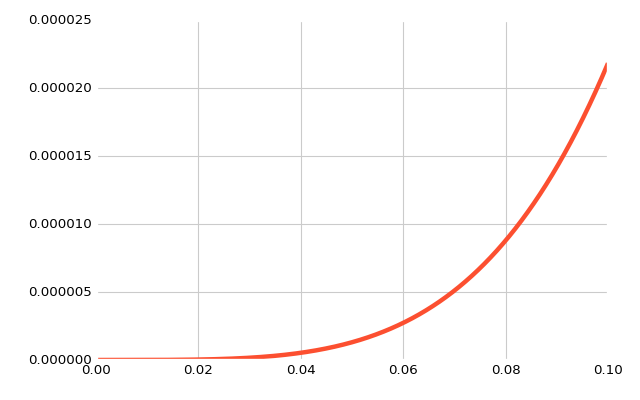

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
axes.plot(T,Tau_e)
fig.savefig('dfim_tau_e.svg', bbox_inches='tight')


In [ ]:
struct = d2np(d)
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
struct['beta'] = 0.0
nu_ws = np.linspace(5,10,10)
omegas = np.linspace(0.1,3.5,100)
for nu_w in nu_ws:
    P_w = []
    Omega = []
    for omega in omegas:
        struct['nu_w'] = nu_w
        struct['omega_t'] = omega
        wind_turbine_fit(struct,0)
        P_w += [float(struct['p_w'])]
        Omega += [float(struct['omega_t'])]
    axes.plot(Omega,np.array(P_w)/1e6)

omega = 1
Nu = np.linspace(2,12,50)
omegas_opt = []
p_ref_opt = []
for nu in Nu:
    struct['nu_w'] = nu
    for it in range(500):
        struct['omega_t'] = omega
        mppt_fit(struct,0)  
        wind_turbine_fit(struct,0)  
        p_ref = float(struct['p_mppt'])
        p_t = float(struct['p_w'])
        omega += 0.0000001*(-p_ref + p_t)/omega
        if abs(-p_ref + p_t)<0.01:
            break
    
    omegas_opt += [float(struct['omega_t'])]
    p_ref_opt += [float(struct['p_w'])] 
        
axes.set_ylabel('$\sf P_t$')
axes.set_xlabel('$\sf \omega_t$')
axes.set_ylim([0,2.5])
axes.set_xlim([0,3.0])

fig.savefig('w_p_t.svg', bbox_inches='tight')
axes.plot(np.array(omegas_opt),np.array(p_ref_opt)/1e6)   

fig.savefig('w_p_t_mppt.svg', bbox_inches='tight')


## without MPPT

In [ ]:
struct = d2np(d)
struct['nu_w'] = 5.0
for it in range(10000):
    wecs_mech_1(struct,0)
    struct[0]['x'] += 100.0e-3*struct[0]['f'][0,0]
print(struct['omega_t'])
print(struct['p_w']/1e6)

## with MPPT

In [ ]:
struct['omega_t'] = 1.0
struct['omega_r'] = 1.0*20
struct['nu_w'] = 8.5
t = 0.0
Omega_t = []
P_w = []
T = []
Dt = 100.0e-3
for it in range(500):
    if t>10.0:
        struct['nu_w'] = 6.0
        
    wecs_mech_1(struct,0)
    mppt_fit(struct,0)  
    struct['tau_t'] = struct['p_w']/struct['omega_t']
    struct['tau_r'] = struct['p_mppt']/struct['omega_r']
    wind_turbine_fit(struct,0)  
    struct[0]['x'] += Dt*struct[0]['f'][0,0]
    struct['omega_t'] = float(struct[0]['x'])
    Omega_t += [float(struct['omega_t'])]
    P_w += [float(struct['p_w'])]
    T += [t]
    t+= Dt
P_w = np.array(P_w)
print(struct['omega_t'])
print(struct['p_w']/1e6)

In [ ]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)

axes.plot(T,Omega_t)


In [ ]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)

axes.plot(T,P_w/1e6)

In [ ]:
struct['beta_ref'] = 0.0
struct['beta'] = 0.0
for it in range(1000):
    t = it*struct['Dt']
    if t>0.1:
        struct['beta_ref'] = 5.0
        
    pitch(struct,0)
    print(t, struct['beta'])